In [1]:
from utils import *
import polars as pl
import pandas as pd
import gower
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

In [2]:
# Read the csv files of the transactions
file_path_transactions = "../data/processed/transactions.parquet"
transactions = pl.read_parquet(file_path_transactions)
pd_transactions = transactions.to_pandas()
pd_transactions.sort_values(by=['account_id', 'invoice_date'])
# Read the csv files of the atributes
file_path_atributes = "../data/processed/atributes.parquet"
atributes = pl.read_parquet(file_path_atributes)
pd_atributes = atributes.to_pandas()
pd_atributes['poc'] = pd_atributes['poc'].astype(str)
pd_atributes.head()

,column_0,poc,bussinesssegment,totalvolumen,skudistintospromediosxorden,skudistintostotales,concentracion,segmentounico,canal
0,10,175519,HighUsage,5.18752,4.1000,16,Medio,4.Activos,Kioscos/Maxikioscos
1,13,28533,HighUsage,4.76866,3.9211,34,Alto,4.Activos,Tradicional
2,19,32182,PowerUsage,5.97930,6.7500,34,Alto,4.Activos,Tradicional
3,20,327976,MinimalUsage,6.02852,3.5833,14,Alto,4.Activos,COMIDA
4,24,354640,PowerUsage,7.52500,3.2000,18,Bajo,4.Activos,Tradicional


## Feature Engineer

### Aplicar la distancia de Gower y la agrupación jerárquica para segmentar a los usuarios

Distancia de Gower: esta métrica de distancia es ideal para conjuntos de datos con tipos mixtos (numéricos, ordinales categóricos y nominales categóricos).

Agrupamiento jerárquico: utilizamos la función de enlace con el método "promedio" para realizar la agrupación aglomerativa.

Dendrograma: el dendrograma ayuda a visualizar el proceso de agrupación y a decidir dónde cortar el árbol para formar los clústeres.

Asignación de clústeres: utilizamos fcluster para asignar etiquetas de clústeres en función del dendrograma.

In [3]:
# Compute Gower distance matrix
gower_dist = gower.gower_matrix(pd_atributes)

/var/folders/02/wzc8k1dn7bsgd14yfq9md5l40000gn/T/ipykernel_25097/239279650.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(gower_dist, method='average')


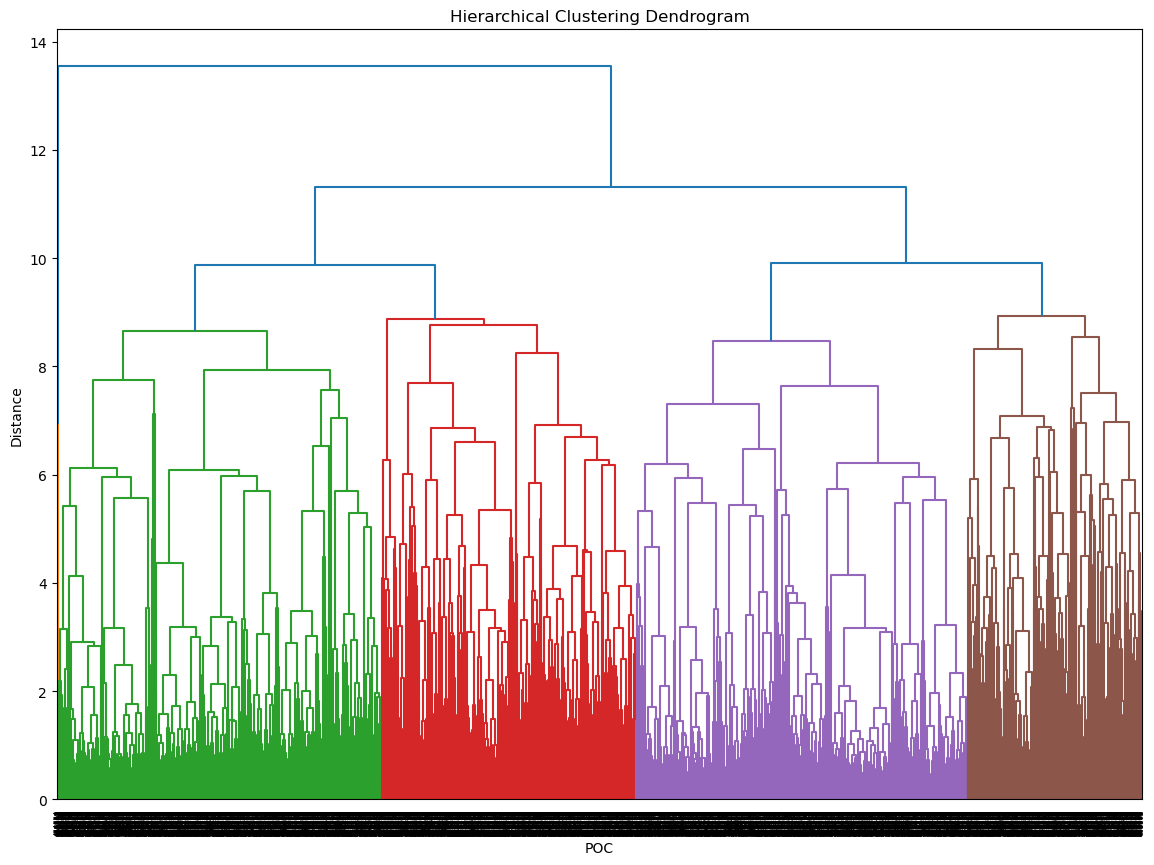

In [4]:
# Perform hierarchical clustering using the Gower distance matrix
Z = linkage(gower_dist, method='average')

# Plot the dendrogram to visualize the clusters
plt.figure(figsize=(14, 10))
dendrogram(Z, labels=pd_atributes['poc'].values)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("POC")
plt.ylabel("Distance")
plt.show()

In [5]:
num_clusters = 6
clusters = fcluster(Z, t=num_clusters, criterion='maxclust')
pd_atributes['cluster'] = clusters
pd_atributes.groupby(by=clusters).count()['poc']

1       5
2    1313
3    1031
4    1343
5     417
6     291
Name: poc, dtype: int64

In [6]:
# Group by the clusters to understand their characteristics
numerical = ["totalvolumen","skudistintospromediosxorden","skudistintostotales"]
pd_atributes.groupby('cluster')[numerical].describe().T

cluster                                      1            2            3  \
totalvolumen                count     5.000000  1313.000000  1031.000000   
                            mean    920.381354    15.442391    24.081094   
                            std    1875.761121    66.571897    83.172525   
                            min      13.441700     0.054920     0.021240   
                            25%      56.252500     2.091260     1.987300   
                            50%      97.355290     5.268540     6.414940   
                            75%     160.413120    11.788420    18.994970   
                            max    4274.444160  1281.067160  1691.436000   
skudistintospromediosxorden count     5.000000  1313.000000  1031.000000   
                            mean      7.869040     6.474492     6.504067   
                            std       4.073639     3.517596     3.376117   
                            min       2.343600     0.750000     0.702700   
                            25%       4.809500     4.000000     4.000000   
                            50%       9.608700     5.750000     5.764700   
                            75%      11.166700     8.111100     8.142900   
                            max      11.416700    33.000000    27.428600   
skudistintostotales         count     5.000000  1313.000000  1031.000000   
                            mean     91.000000    31.926123    28.736178   
                            std      50.438081    23.144987    23.298240   
                            min      32.000000     1.000000     1.000000   
                            25%      68.000000    14.000000    11.000000   
                            50%      70.000000    26.000000    22.000000   
                            75%     128.000000    44.000000    40.000000   
                            max     157.000000   150.000000   126.000000   

cluster                                      4            5            6  
totalvolumen                count  1343.000000   417.000000   291.000000  
                            mean     18.181856    36.564326    29.650284  
                            std      79.536553   109.588173   135.287429  
                            min       0.025080     0.062060     0.045000  
                            25%       2.097970     5.262060     1.142080  
                            50%       4.934000    13.137060     3.301280  
                            75%      10.292390    28.713640     7.449120  
                            max    1322.642780  1623.862640  1665.981700  
skudistintospromediosxorden count  1343.000000   417.000000   291.000000  
                            mean      5.041289     6.068862     5.021730  
                            std       2.492491     3.478607     2.850529  
                            min       0.750000     0.750000     0.750000  
                            25%       3.292850     3.636400     3.000000  
                            50%       4.500000     5.216200     4.142900  
                            75%       6.191400     7.375000     6.112500  
                            max      21.000000    24.125000    17.333300  
skudistintostotales         count  1343.000000   417.000000   291.000000  
                            mean     23.651526    33.599520    16.109966  
                            std      17.376366    21.765916    15.034957  
                            min       1.000000     3.000000     1.000000  
                            25%      11.000000    17.000000     7.000000  
                            50%      19.000000    27.000000    11.000000  
                            75%      31.000000    46.000000    19.000000  
                            max     123.000000   113.000000   129.000000

In [7]:
pd_transactions_cluster = pd_transactions.merge(pd_atributes[['poc', 'cluster']], how='left', left_on='account_id', right_on='poc')
print(pd_transactions_cluster.shape[0])
print(100* (pd_transactions_cluster.poc.isnull().sum()/pd_transactions.shape[0]))
pd_transactions_cluster.isnull().sum()

280828
0.7235745723360918


                       0
account_id             0
sku_id                 0
invoice_date           0
order_id               0
items_phys_cases       0
poc                 2032
cluster             2032
dtype: int64

In [8]:
pd_transactions_cluster.dropna(inplace=True)
print(pd_transactions_cluster.shape)
pd_transactions_cluster.isnull().sum()

(278796, 8)


                    0
account_id          0
sku_id              0
invoice_date        0
order_id            0
items_phys_cases    0
poc                 0
cluster             0
dtype: int64

In [9]:
pd_transactions_cluster.to_parquet("../data/processed/pd_transactions_cluster.parquet")

## Entrenamiento del modelo utilizando la variable de clusterización que creamos y el algoritmo TIFUKNN.

El proceso es el siguiente:

* Agregar segmentación al dataset de transacciones: asignar a cada usuario en el conjunto de datos de transacciones a un clúster según los resultados de la segmentación.

* Construir una matriz de usuario-artículo por grupo: construimos la matriz de usuario-artículo por separado para cada grupo.

* Calcular la similitud de los elementos: calculamos la similitud del coseno entre los elementos dentro de cada grupo.

* Predecir la próxima canasta con TIFUKNN: mejoraamos el algoritmo TIFUKNN considerando solo usuarios similares dentro del mismo grupo.

* Evaluar el modelo: medimos la efectividad de tus predicciones usando precisión, recuperación y puntaje F1. Además de nuestra de efectividad sobre 3 SKU

Este enfoque garantiza que la predicción de la próxima canasta se adapte al comportamiento específico de los usuarios dentro del mismo grupo, lo que genera recomendaciones más personalizadas y precisas. 

### Separación de los datos

In [10]:
# Function to create train and test datasets using biweekly periods
train_data, test_data = split_train_test_iso(pd_transactions_cluster)
print(100*train_data.shape[0]/pd_transactions.shape[0])
train_data.head()

86.3222328257866


,,account_id,sku_id,invoice_date,order_id,items_phys_cases,poc,cluster,biweekly_period
0,0,430606,7038,2022-07-29,512-3880249-0,100,430606,3.0,15
1,1,323267,14933,2022-07-29,512-3882307-0,1,323267,6.0,15
2,2,357825,21971,2022-07-23,512-3852880-0,8,357825,3.0,14
3,3,444926,7038,2022-08-05,512-3913163-0,20,444926,3.0,15
4,4,450771,7030,2022-08-16,512-3957000-0,5,450771,6.0,16


In [11]:
# Build the item-user matrix by cluster
cluster_item_user_matrices = build_item_user_matrix_by_cluster(train_data, 
                                                               cluster_col='cluster',
                                                               sku_col='sku_id',
                                                               user_col='account_id',
                                                               qty_col='items_phys_cases')
# Compute item similarity for each cluster
cluster_item_similarity = compute_similarity_by_cluster(cluster_item_user_matrices, 
                                                        train_data, 
                                                        cluster_col='cluster', 
                                                        user_col='account_id')

In [12]:
predicted_baskets, ground_truth_baskets, user_histories, main_strategy_count, fallback1_count, fallback2_count = predict_next_baskets_for_all(
    test_data=test_data,
    cluster_item_similarity=cluster_item_similarity,
    train_data=train_data,
    user_col='account_id',
    cluster_col='cluster',
    sku_col='sku_id',
    k=14
)

print(f"Main strategy used: {main_strategy_count}")
print(f"Fallback 1 used: {fallback1_count}")
print(f"Fallback 2 used: {fallback2_count}")
# Evaluate the model
metrics = evaluate_model_metrics(predicted_baskets, ground_truth_baskets, user_histories, k=5, n=2)
# Print the evaluation results
for metric_name, score in metrics.items():
    print(f"{metric_name}: {score:.4f}")

Main strategy used: 3232
Fallback 1 used: 0
Fallback 2 used: 0
Avg Precision@k: 0.3614
Avg Recall@k: 0.2604
Avg F1@k: 0.2622
Avg NDCG@k: 0.4668
Avg PHR@k: 0.8472
Avg Repetition Ratio: 0.5447
Avg Exploration Ratio: 0.4553
Avg Recallrep: 0.5530
Avg Recallexpl: 0.0487
Avg PHRrep: 0.8994
Avg PHRexpl: 0.1117
Avg Precision@k over n: 0.9035


Average Basket Size: 11.1767
25th Percentile: 4.0000
50th Percentile (Median): 8.0000
75th Percentile: 14.0000
maximum Basket Size: 111.0000


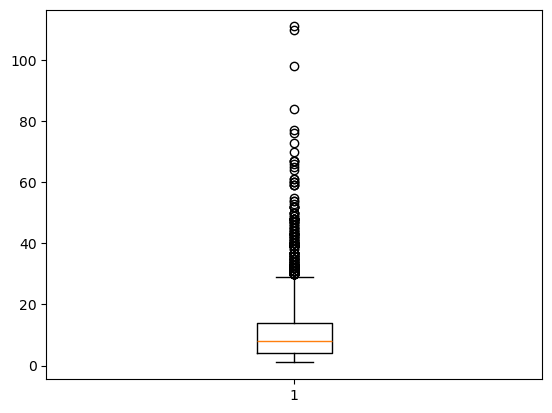

In [13]:
basket_stats = calculate_basket_statistics(ground_truth_baskets)
print(f"Average Basket Size: {basket_stats['average_size']:.4f}")
print(f"25th Percentile: {basket_stats['percentile_25']:.4f}")
print(f"50th Percentile (Median): {basket_stats['percentile_50']:.4f}")
print(f"75th Percentile: {basket_stats['percentile_75']:.4f}")
print(f"maximum Basket Size: {basket_stats['max_size']:.4f}")
plt.boxplot(basket_stats['basket_sizes']);

Average Basket Size: 14.0000
25th Percentile: 14.0000
50th Percentile (Median): 14.0000
75th Percentile: 14.0000
maximum Basket Size: 14.0000


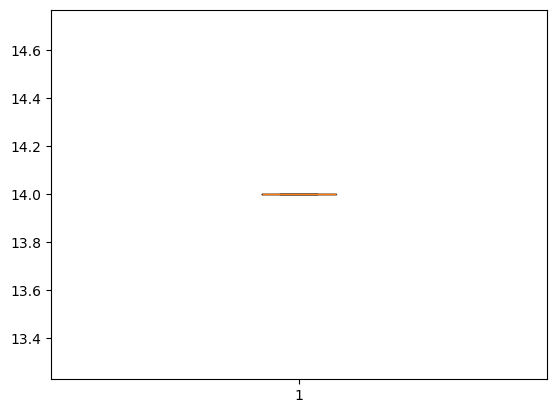

In [14]:
basket_stats = calculate_basket_statistics(predicted_baskets)
print(f"Average Basket Size: {basket_stats['average_size']:.4f}")
print(f"25th Percentile: {basket_stats['percentile_25']:.4f}")
print(f"50th Percentile (Median): {basket_stats['percentile_50']:.4f}")
print(f"75th Percentile: {basket_stats['percentile_75']:.4f}")
print(f"maximum Basket Size: {basket_stats['max_size']:.4f}")
plt.boxplot(basket_stats['basket_sizes']);

## Inference 

This is the model trained on the all dataset and it's showing you how to use the function to predict the next basket for one account id. As you can see the algorithm takes 6 seconds in calculate the matrix with item-user similarity by cluster and the prediction happens in less than 1 second, so it's possible to use a lambda function in AWS or something similar in Azure or GCP to delivery it in production.

We have choosed to leave the number of items (k_item) in five, since it was the best combination of good results in training and a number of items that could be display as recommendation on the app withouth generate the need for scrolling down too much

In [15]:
cluster_item_user_matrices = build_item_user_matrix_by_cluster(pd_transactions_cluster, 
                                                               cluster_col='cluster',
                                                               sku_col='sku_id',
                                                               user_col='account_id',
                                                               qty_col='items_phys_cases')
cluster_item_similarity = compute_similarity_by_cluster(cluster_item_user_matrices, 
                                                        pd_transactions_cluster, 
                                                        cluster_col='cluster', 
                                                        user_col='account_id')

In [16]:
predicted_baskets, ground_truth_baskets, user_histories, main_strategy_count, fallback1_count, fallback2_count = predict_next_baskets_for_all(
    test_data=test_data,
    cluster_item_similarity=cluster_item_similarity,
    train_data=train_data,
    user_col='account_id',
    cluster_col='cluster',
    sku_col='sku_id',
    k=14
)

# Display some of the predictions
print("Predicted Baskets:")
for account_id, basket in predicted_baskets.items():
    print(f"Account {account_id}: {basket}")
    break

Predicted Baskets:
Account 449679: ['7038', '24880', '7026', '19019', '15605', '26567', '7030', '27086', '7634', '21810', '16668', '16667', '19337', '76483']


In [18]:
# Example usage:
predicted_basket = predict_next_basket_for_user(
    account_id='430606',
    test_data=test_data,
    cluster_item_similarity=cluster_item_similarity,
    train_data=train_data,
    user_col='account_id',
    cluster_col='cluster',
    sku_col='sku_id',
    k=14
)

print(f"Predicted basket for account_id '430606': {predicted_basket}")

Predicted basket for account_id '430606': ['7038', '899', '19338', '19087', '24684', '25643', '25979', '19088', '11522', '1416', '24880', '19341', '26567', '7030']


Average Basket Size: 14.0000
25th Percentile: 14.0000
50th Percentile (Median): 14.0000
75th Percentile: 14.0000
maximum Basket Size: 14.0000


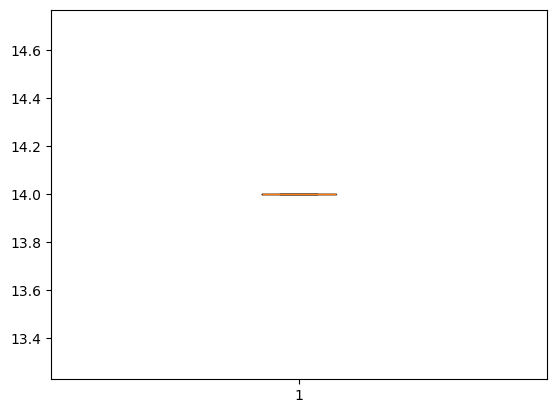

In [19]:
basket_stats = calculate_basket_statistics(predicted_baskets)
print(f"Average Basket Size: {basket_stats['average_size']:.4f}")
print(f"25th Percentile: {basket_stats['percentile_25']:.4f}")
print(f"50th Percentile (Median): {basket_stats['percentile_50']:.4f}")
print(f"75th Percentile: {basket_stats['percentile_75']:.4f}")
print(f"maximum Basket Size: {basket_stats['max_size']:.4f}")
plt.boxplot(basket_stats['basket_sizes']);

In [37]:
# Convert both lists to sets
set_predicted_keys = set(predicted_baskets.keys())
set_transactions_ids = set(pd_transactions.account_id.unique().tolist())
set_atributes_ids = set(pd_atributes.poc.unique().tolist())

# Find the intersection with the transactions (elements present in both sets)
common_elements = list(set_predicted_keys & set_transactions_ids)
print(len(common_elements)/ len(pd_transactions.account_id.unique()))

# Find the intersection with the atributes (elements present in both sets)
common_elements = list(set_predicted_keys & set_atributes_ids)
print(len(common_elements)/ len(pd_atributes.poc.unique()))

0.7126791620727674
0.7345454545454545
